In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.dates import DateFormatter
import pandas as pd
from scipy import integrate 
from scipy import optimize
from scipy import stats
from scipy.interpolate import interp1d
from datetime import datetime
from metpy.units import units
from siphon.simplewebservice.wyoming import WyomingUpperAir

# Read data

In [2]:
%run profile_read_py.py

In [3]:
arquivo = '/Volumes/GoogleDrive/My Drive/Estudos/IC/Henrique/Programs/RMlicelPython/30/RM1183010.264' #30 agosto 2011
#arquivo = '/Users/costaleirbag/Downloads/2/04' + f'/{file_test}'
#arquivo = '/Volumes/GoogleDrive/My Drive/Estudos/IC/Henrique/Programs/RMlicelPython/30/' + f'{file_test}'

read = profile_read(arquivo)
phy  = read[1]

df = pd.DataFrame(phy)

# Aqui é um jeito provisório de fazer o header

lista = []
for i in range(len(read[0]['ch']['active'])):
    wlen = str(read[0]['ch']['wlen'][i])
    pol = str(read[0]['ch']['pol'][i])
    photon = read[0]['ch']['photons'][i]
    an = 'analog' if photon == 0 else 'photon'
    tr = read[0]['ch']['tr'][i]
    lista.append(wlen + ' ' + pol + ' ' + an + ' ' + tr[-1])

###############################################


df.columns = lista
alt = 7.5*(np.array(df.index) + 1)

df['alt'] = alt
s355 = df['355 o analog 0']

df.set_index('alt', inplace=True)

In [4]:
read[0]

{'file': 'RM1183010.264',
 'site': 'Embrapa_',
 'datei': '30/08/2011',
 'houri': '10:25:46',
 'datef': '30/08/2011',
 'hourf': '10:26:47',
 'jdi': 734745.4345601852,
 'jdf': 734745.4352662037,
 'alt': 100,
 'lon': -60.0,
 'lat': -2.9,
 'zen': -90.0,
 'T0': 30.0,
 'P0': 1013.0,
 'nshoots': 600,
 'nhz': 10,
 'nshoots2': 600,
 'nhz2': 10,
 'nch': 5,
 'ch': {'active': array([1, 1, 1, 1, 1]),
  'photons': array([0, 1, 0, 1, 1]),
  'elastic': array([1, 1, 2, 2, 2]),
  'ndata': array([4000, 4000, 4000, 4000, 4000]),
  'pmtv': array([950, 950, 990, 990, 990]),
  'binw': array([7.5, 7.5, 7.5, 7.5, 7.5]),
  'wlen': array([355, 355, 387, 387, 408]),
  'pol': array(['o', 'o', 'o', 'o', 'o'], dtype='<U6'),
  'bits': array([12,  0, 12,  0,  0]),
  'nshoots': array([600, 600, 600, 600, 600]),
  'discr': array([0.5   , 3.1746, 0.02  , 3.1746, 3.1746]),
  'tr': array(['BT0', 'BC0', 'BT1', 'BC1', 'BC2'], dtype='<U6')}}

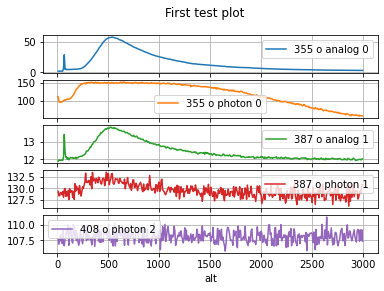

In [5]:
plot = df[:3000].plot(grid=True, subplots=True, title='First test plot')

# Reading multiple data (mean signal)

The idea here is to iterate over the data files in a month directory.

In [6]:
import os

directory = '/Volumes/GoogleDrive/My Drive/Estudos/IC/Henrique/Programs/RMlicelPython/30'
#directory = '/Users/costaleirbag/Downloads/9/02'

# Primeiro testo um arquivo pra saber o tamanho do array gerado, e ai gerar o dataframe
# ja certo.

files = os.listdir(directory)
files.sort()

file_test = files[0]
path = os.path.join(directory, file_test)
read = profile_read(path)
array_size = len(read[1][:, 0])

In [7]:
file_test

'RM1183000.002'

In [8]:
n_files = len(files)
n_files

1248

In [9]:
#n_files = 100
data    = np.zeros((array_size, n_files))
date    = []

cont    = 0
errors  = []

for filename in files[:n_files]:
    print(f'Arquivo: {cont+1}', end='\r')
    path = os.path.join(directory, filename)
    try:
        head, phy, raw = profile_read(path)
        date_str = head['datei'] + ' ' + head['houri']
        date.append(datetime.strptime(date_str, "%d/%m/%Y %H:%M:%S"))
        data[:, cont] = phy[:, 0]
    except OverflowError as e:
        errors.append(str(cont))
        print(f"Overflow error happened at file {cont}.")
        print(f"{e}, {e.__class__}")
        data[:, cont] = np.nan
        date_str = head['datei'] + ' ' + head['houri']
        date.append(datetime.strptime(date_str, "%d/%m/%Y %H:%M:%S"))
    phy = read[1]
    cont += 1
    #print(data)

#date = np.array(date)

errors_str = ', '.join(errors)
print(f'\n  All files with overflow: {errors_str}.')

Overflow error happened at file 483.
int too big to convert, <class 'OverflowError'>
Overflow error happened at file 484.
int too big to convert, <class 'OverflowError'>
Overflow error happened at file 744.
int too big to convert, <class 'OverflowError'>
Arquivo: 1248
  All files with overflow: 483, 484, 744.


In [10]:
data.shape

(4000, 1248)

In [11]:
bg_vec = np.mean(data[-500:], axis=0)
bg_vec.shape

(1248,)

In [13]:
data_nobg = data - bg_vec

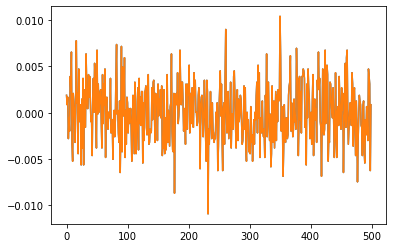

In [14]:
plt.plot(data_nobg[-500:, 0])
plt.plot(data[-500:, 0] - bg_vec[0])

In [15]:
data_nobg.shape

(4000, 1248)

In [16]:
(data_nobg.T * alt * alt).T

array([[-4.78179932e-01, -7.94906616e-02, -3.16200256e-01, ...,
        -2.58087158e-01, -1.20391846e-01, -4.57626343e-01],
       [-1.91271973e+00, -1.64547729e+00, -1.72256470e+00, ...,
        -2.35986328e+00, -1.71752930e+00, -2.74603271e+00],
       [-5.12759399e+00,  4.17549133e-01,  2.71602631e+00, ...,
        -1.08682251e+00, -3.04046631e+00, -2.05870056e+00],
       ...,
       [ 2.78334738e+06, -5.38889417e+05, -1.94446521e+06, ...,
        -3.75942135e+06,  8.19492393e+05, -1.80727340e+05],
       [-5.63390074e+06, -6.39560471e+06, -5.78873053e+06, ...,
        -5.77445544e+06,  2.28401381e+06, -2.37698489e+06],
       [ 7.71972656e+05, -2.73669434e+06, -2.12951660e+06, ...,
        -2.11523438e+06,  1.36962891e+06, -3.84301758e+06]])

In [17]:
data_pr2 = pd.DataFrame((data_nobg.T * alt * alt).T, columns=date)
data_pr2['Altitude'] = alt
data_pr2.set_index('Altitude', inplace=True)


# Tirando medias de 5 em 5 min
data_pr2.columns = pd.to_datetime(data_pr2.columns)
data_pr2 = data_pr2.resample('5T', axis=1).mean()


data_pr2

,2011-08-29 23:55:00,2011-08-30 00:00:00,2011-08-30 00:05:00,2011-08-30 00:10:00,2011-08-30 00:15:00,2011-08-30 00:20:00,2011-08-30 00:25:00,2011-08-30 00:30:00,2011-08-30 00:35:00,2011-08-30 00:40:00,...,2011-08-30 23:10:00,2011-08-30 23:15:00,2011-08-30 23:20:00,2011-08-30 23:25:00,2011-08-30 23:30:00,2011-08-30 23:35:00,2011-08-30 23:40:00,2011-08-30 23:45:00,2011-08-30 23:50:00,2011-08-30 23:55:00
Altitude,,,,,,,,,,,,,,,,,,,,,
7.5,-4.781799e-01,-2.064560e-01,-2.644913e-01,-3.269257e-01,-7.495422e-02,-3.808685e-01,-4.200943e-01,-2.234848e-01,-1.354523e-01,-1.989624e-01,...,-0.330171,-4.336761e-01,-3.227921e-01,-4.475052e-01,-4.343857e-01,-0.338086,-0.341331,-2.307220e-01,-2.693253e-01,-2.513924e-01
15.0,-1.912720e+00,-1.008929e+00,-9.206360e-01,-1.545740e+00,-3.364380e-01,-7.544312e-01,-1.854327e+00,-6.375916e-01,-5.692749e-01,-1.226147e+00,...,-1.558722,-2.055139e+00,-1.025665e+00,-2.000592e+00,-1.252313e+00,-0.967822,-1.511810,-5.200562e-01,-1.489288e+00,-1.772324e+00
22.5,-5.127594e+00,-2.307541e-01,-3.307393e+00,-3.086526e+00,-1.560361e+00,-8.528961e-01,-1.926906e+00,-1.393382e+00,-1.466263e+00,-6.988953e-01,...,-3.012740,-4.047281e+00,-1.813362e+00,-4.810323e+00,-3.497484e+00,-2.774982,-2.886589,-9.023346e-01,-2.320930e+00,-2.030788e+00
30.0,-1.021436e+01,-3.266675e+00,-3.645923e+00,-4.315283e+00,-1.235889e+00,-2.102197e+00,-6.062329e+00,-2.843335e+00,-1.910889e+00,-2.707324e+00,...,-6.308130,-9.209326e+00,-6.446411e+00,-5.475513e+00,-5.631812e+00,-3.798047,-3.483765,-4.460596e+00,-3.796509e+00,-5.578674e+00
37.5,-1.023788e+01,-6.305809e+00,-9.473305e+00,-6.399307e+00,-2.217178e+00,-8.091202e+00,-4.379768e+00,-3.756065e+00,-5.274582e+00,-5.431824e+00,...,-6.194344,-1.164299e+01,-8.813667e+00,-9.814339e+00,-5.595360e+00,-3.302307,-4.699516,-4.337540e+00,-5.417061e+00,-6.284809e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29970.0,4.242479e+06,-4.825052e+05,3.816330e+05,-1.163539e+06,-1.123774e+06,3.141656e+05,4.187657e+05,4.882067e+05,3.223524e+05,-1.568928e+06,...,136908.389136,-6.021630e+05,1.022244e+06,6.023823e+05,-8.693281e+05,887675.108203,68344.550903,-2.551189e+06,2.168386e+06,-4.051333e+05
29977.5,3.513279e+06,1.820923e+06,-4.226319e+05,-7.253268e+05,8.502369e+05,3.508891e+05,2.356983e+06,-1.303292e+06,-7.971428e+04,9.899197e+05,...,246675.468554,-1.370354e+06,-3.301926e+05,-1.408456e+06,5.563179e+05,778420.897503,-626378.709801,4.825273e+05,2.680301e+05,-2.225052e+05
29985.0,2.783347e+06,-8.854176e+05,1.113705e+06,2.164484e+06,-2.112681e+06,-1.075730e+06,-1.446624e+06,-2.218556e+06,1.273872e+06,-1.716837e+06,...,393136.841547,-1.741421e+04,-1.474355e+05,1.810273e+06,1.763884e+06,-647984.341846,653764.689971,1.535085e+05,-1.707398e+06,-3.598084e+05


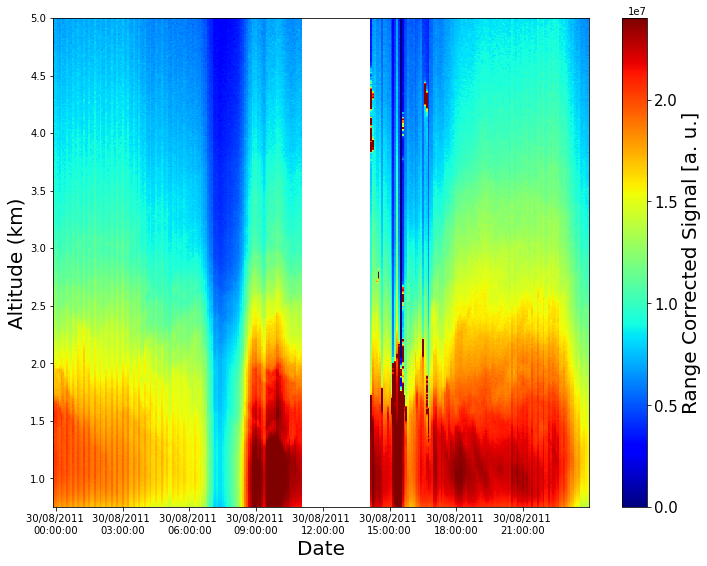

In [18]:
norm = colors.LogNorm()

fig, ax = plt.subplots(figsize = (12,9))

psm = ax.pcolormesh(data_pr2.columns, alt*1e-3, (data_pr2), vmin = 0, vmax=2.4e7, cmap='jet')

cbar = fig.colorbar(psm, ax=ax, label = "Range Corrected Signal [a. u.]")

ax.set_xlabel("Date", fontsize=20)

ax.set_ylabel("Altitude (km)", fontsize=20)

ax.set_ylim(0.75, 5)

cbar.ax.tick_params(labelsize=15)

ax.figure.axes[-1].yaxis.label.set_size(20)

date_form = DateFormatter("%d/%m/%Y \n%H:%M:%S")
ax.xaxis.set_major_formatter(date_form)

plt.show()

In [20]:
maximum_value = data_pr2.max().max()

# Tirando as médias

In [21]:
################

initial = 600
final = initial + 30             # Tomando medias de 30 minutos

data = np.zeros((array_size, final - initial))
cont = 0

files = os.listdir(directory)
files.sort()                          # A lista tem que estar ordenada para as medias.

for filename in files[initial:final]:
    path = os.path.join(directory, filename)
    read = profile_read(path)
    data[:, cont] = read[1][:, 0]
    phy = read[1]
    cont += 1
    #print(data)

In [22]:
read[0]

{'file': 'RM1183010.324',
 'site': 'Embrapa_',
 'datei': '30/08/2011',
 'houri': '10:31:49',
 'datef': '30/08/2011',
 'hourf': '10:32:49',
 'jdi': 734745.4387615741,
 'jdf': 734745.4394560185,
 'alt': 100,
 'lon': -60.0,
 'lat': -2.9,
 'zen': -90.0,
 'T0': 30.0,
 'P0': 1013.0,
 'nshoots': 600,
 'nhz': 10,
 'nshoots2': 600,
 'nhz2': 10,
 'nch': 5,
 'ch': {'active': array([1, 1, 1, 1, 1]),
  'photons': array([0, 1, 0, 1, 1]),
  'elastic': array([1, 1, 2, 2, 2]),
  'ndata': array([4000, 4000, 4000, 4000, 4000]),
  'pmtv': array([950, 950, 990, 990, 990]),
  'binw': array([7.5, 7.5, 7.5, 7.5, 7.5]),
  'wlen': array([355, 355, 387, 387, 408]),
  'pol': array(['o', 'o', 'o', 'o', 'o'], dtype='<U6'),
  'bits': array([12,  0, 12,  0,  0]),
  'nshoots': array([600, 600, 600, 600, 600]),
  'discr': array([0.5   , 3.1746, 0.02  , 3.1746, 3.1746]),
  'tr': array(['BT0', 'BC0', 'BT1', 'BC1', 'BC2'], dtype='<U6')}}

## Para conferir se os dados estão sendo lidos

In [23]:
#os.listdir(directory)

In [24]:
df = pd.DataFrame(data)
#df.columns = lista
df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.696574,1.686605,1.700033,1.697184,1.720581,1.713460,1.722209,1.730754,1.716919,1.706340,...,1.730550,1.756999,1.761678,1.731974,1.724854,1.742961,1.732381,1.749268,1.747843,1.752116
1,1.702271,1.701253,1.687826,1.704712,1.707357,1.709798,1.711019,1.726481,1.729126,1.719360,...,1.729940,1.736247,1.726888,1.750285,1.730754,1.773478,1.728719,1.761068,1.744995,1.748047
2,1.698812,1.701864,1.691081,1.711833,1.700439,1.707153,1.723633,1.712646,1.717122,1.722005,...,1.743571,1.729940,1.742757,1.751709,1.748454,1.763102,1.755778,1.746419,1.743368,1.753133
3,1.698201,1.694132,1.691895,1.709188,1.701457,1.709798,1.717326,1.726888,1.715291,1.738892,...,1.752930,1.740519,1.738078,1.743978,1.746826,1.747233,1.742554,1.736857,1.749064,1.755168
4,1.701660,1.714478,1.700439,1.707153,1.714071,1.702067,1.711222,1.713257,1.703491,1.726481,...,1.734009,1.736043,1.740519,1.746623,1.739299,1.747437,1.739502,1.750692,1.752726,1.758626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1.706340,1.691895,1.712850,1.710205,1.721191,1.706746,1.716919,1.714681,1.723022,1.719360,...,1.747233,1.743978,1.738892,1.735026,1.738281,1.739502,1.748047,1.740112,1.742147,1.753337
3996,1.706136,1.711019,1.691081,1.708171,1.724243,1.714274,1.717529,1.717326,1.739502,1.723633,...,1.746012,1.765747,1.754557,1.738688,1.732788,1.738281,1.744385,1.744995,1.755981,1.743978
3997,1.704915,1.721191,1.696777,1.701050,1.720581,1.730347,1.729126,1.728719,1.729940,1.723226,...,1.746826,1.764323,1.738485,1.717733,1.740926,1.757812,1.732178,1.747030,1.729126,1.740112
3998,1.714681,1.693522,1.710002,1.706543,1.710205,1.722005,1.712240,1.702067,1.717122,1.722819,...,1.723633,1.743978,1.756185,1.728719,1.725057,1.750488,1.745605,1.748454,1.736654,1.729940


In [25]:
s355 = df.mean(axis=1)
s355

0       1.726407
1       1.726861
2       1.727905
3       1.726902
4       1.726902
          ...   
3995    1.728292
3996    1.732117
3997    1.729770
3998    1.726447
3999    1.728339
Length: 4000, dtype: float64

In [26]:
alt = 7.5*(np.array(s355.index) + 1)

# Applying corrections to signal data

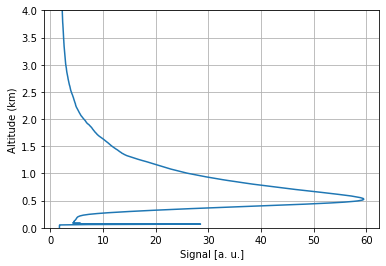

In [27]:
plt.plot(s355, alt*1e-3)
plt.grid(True)
plt.ylabel('Altitude (km)')
plt.xlabel('Signal [a. u.]')
plt.ylim(0, 4)
plt.savefig('fig1', dpi=200)

## Picture for $log(P r^2)$

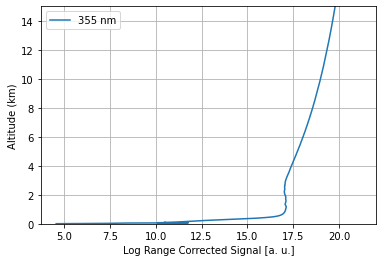

In [28]:
plt.plot(np.log(s355*alt*alt), alt*1e-3)
plt.grid(True)
plt.legend(['355 nm'])
plt.ylabel('Altitude (km)')
plt.xlabel('Log Range Corrected Signal [a. u.]')
plt.ylim(0, 15)
plt.savefig('fig3', dpi=200)

# Read temperature and pressure data

## Usando perfil artificial

z = alt
Pair = read[0]['P0']*np.exp(-(z-100)/8e3)    # H aproximadamente 8km
Tair = read[0]['T0'] - (9.8*1e-3)*z    # 6.5 lapse rate

Pair *= 100
Pair

plt.plot(Pair, alt*1e-3)
plt.grid(True)
plt.xlabel('Pressure [pa]')
plt.ylabel('Altitude [km]')
plt.ylim(0, 15)
plt.savefig('fig4', dpi=200)

Tair = read[0]['T0']+273.15 -0.006666666666668182*alt[:int(12000/7.5)]
Tair_p = Tair[-1]*np.ones(len(alt[int(12000/7.5):]))
Tair = np.concatenate((Tair, Tair_p), axis=0)

plt.plot(Tair, alt*1e-3)
plt.grid(True)
plt.xlabel('Temperature [K]')
plt.ylabel('Altitude [km]')
plt.ylim(0, 15)
plt.savefig('fig5', dpi=200)

PairTair = pd.read_fwf('PairTair.txt', header=None)

PairTair

## Usando dados de Wyoming

In [30]:
head = read[0]
date = datetime.strptime(head['datei'], '%d/%m/%Y').date()
print('Data:', date)
station = 'SBMN'

PairTair = WyomingUpperAir.request_data(date, station)

Data: 2011-08-30


In [31]:
PairTair

,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation,pw
0,1001.0,84,28.8,22.8,80.0,1.0,-0.984808,-0.173648,SBMN,82332,2011-08-30,-3.15,-59.98,84.0,44.19
1,1000.0,93,29.0,23.0,80.0,1.0,-0.984808,-0.173648,SBMN,82332,2011-08-30,-3.15,-59.98,84.0,44.19
2,992.0,165,31.6,22.6,81.0,2.0,-1.975377,-0.312869,SBMN,82332,2011-08-30,-3.15,-59.98,84.0,44.19
3,986.0,220,31.6,21.6,81.0,3.0,-2.963065,-0.469303,SBMN,82332,2011-08-30,-3.15,-59.98,84.0,44.19
4,947.0,581,28.7,20.0,85.0,10.0,-9.961947,-0.871557,SBMN,82332,2011-08-30,-3.15,-59.98,84.0,44.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,34.0,23162,-61.2,-92.1,220.0,10.0,6.427876,7.660444,SBMN,82332,2011-08-30,-3.15,-59.98,84.0,44.19
85,33.3,23290,-60.9,-91.9,213.0,7.0,3.812473,5.870694,SBMN,82332,2011-08-30,-3.15,-59.98,84.0,44.19
86,33.0,23346,-61.0,-91.9,210.0,6.0,3.000000,5.196152,SBMN,82332,2011-08-30,-3.15,-59.98,84.0,44.19
87,32.0,23537,-61.5,-91.7,185.0,14.0,1.220180,13.946726,SBMN,82332,2011-08-30,-3.15,-59.98,84.0,44.19


In [32]:
PairTair.units

{'pressure': 'hPa',
 'height': 'meter',
 'temperature': 'degC',
 'dewpoint': 'degC',
 'direction': 'degrees',
 'speed': 'knot',
 'u_wind': 'knot',
 'v_wind': 'knot',
 'station': None,
 'station_number': None,
 'time': None,
 'latitude': 'degrees',
 'longitude': 'degrees',
 'elevation': 'meter',
 'pw': 'millimeter'}

In [33]:
alt_min = PairTair['height'].values[0]
alt_max = PairTair['height'].values[-1]
mask_range = np.where((alt >= alt_min) & (alt <= alt_max))[0]

In [34]:
Pair = 100*PairTair['pressure']
Tair = 273.15 + PairTair['temperature']

bg = np.mean(s355[-500:])    # O background eh a media dos ultimos 500 bins
# n_alt = alt[11:3145]       # Preciso ajustar o tamanho dos arrays de altitude e sinal
#                            # pra poder fazer a interpolacao
# n_s355 = s355[11:3145]     # '''

n_alt = alt[mask_range]
n_s355 = s355[mask_range]

x = PairTair['height']
y = Pair
f = interp1d(x, y, kind='cubic')
newPair = f(n_alt)


y = Tair
f = interp1d(x, y, kind='cubic')
newTair = f(n_alt)

In [35]:
bg

1.728537353515625

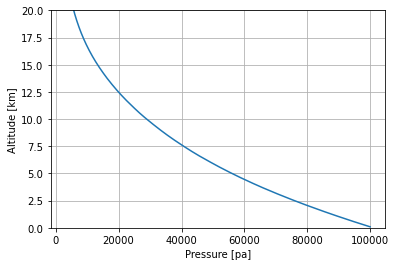

In [36]:
plt.plot(newPair, n_alt*1e-3)
plt.grid(True)
plt.xlabel('Pressure [pa]')
plt.ylabel('Altitude [km]')
plt.ylim(0, 20)
plt.savefig('Pres_profile', dpi=200)

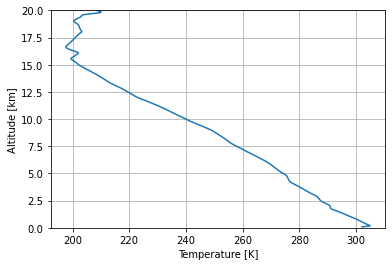

In [37]:
plt.plot(newTair, n_alt*1e-3)
plt.grid(True)
plt.xlabel('Temperature [K]')
plt.ylabel('Altitude [km]')
plt.ylim(0, 20)
plt.savefig('Temp_profile', dpi=200)

# Molecular Scattering

In [38]:
%run alphabeta.ipynb

In [39]:
lambd = 355*1e-9
co2 = 400


alpha_mol, beta_mol, LR_mol = alphabeta(newPair, newTair, lambd, co2)

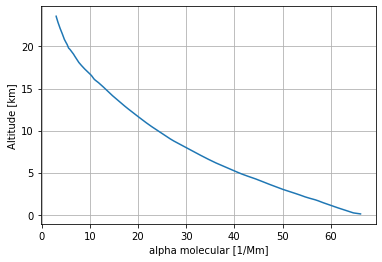

In [40]:
plt.plot(alpha_mol*1e6, n_alt*1e-3)
plt.grid(True)
plt.xlabel('alpha molecular [1/Mm]')
plt.ylabel('Altitude [km]')
plt.savefig('fig6', dpi=200)

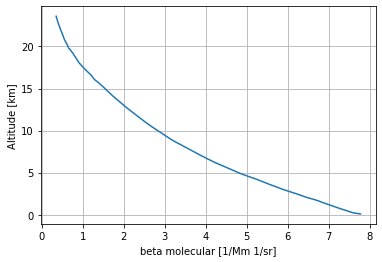

In [41]:
plt.plot(beta_mol*1e6, n_alt*1e-3)
plt.grid(True)
plt.xlabel('beta molecular [1/Mm 1/sr]')
plt.ylabel('Altitude [km]')
plt.savefig('fig7', dpi=200)

# Obtaining overlap

In [42]:
overlap = pd.read_csv('overlap_narrow.csv', header=None)
alt_o = alt[:overlap.shape[0]]
overlap['alt'] = alt_o
overlap.set_index('alt', inplace=True)
overlap

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
alt,,,,,,,,,,,,,,,,,,,,,
7.5,0.000077,0.000090,0.000096,0.000059,0.000063,0.000068,0.000072,0.000096,0.000062,0.000070,...,0.000076,0.000058,0.000040,0.000047,0.000053,0.000042,0.000070,0.000101,0.000112,0.000300
15.0,0.000107,0.000121,0.000129,0.000083,0.000089,0.000095,0.000101,0.000131,0.000088,0.000098,...,0.000106,0.000080,0.000055,0.000065,0.000073,0.000059,0.000092,0.000134,0.000149,0.000397
22.5,0.000140,0.000156,0.000165,0.000110,0.000118,0.000126,0.000132,0.000168,0.000117,0.000131,...,0.000139,0.000105,0.000071,0.000085,0.000096,0.000078,0.000115,0.000169,0.000189,0.000502
30.0,0.000179,0.000195,0.000206,0.000143,0.000154,0.000164,0.000170,0.000212,0.000152,0.000170,...,0.000180,0.000135,0.000092,0.000110,0.000123,0.000101,0.000143,0.000209,0.000234,0.000621
37.5,0.000224,0.000240,0.000252,0.000181,0.000194,0.000206,0.000213,0.000260,0.000193,0.000216,...,0.000225,0.000169,0.000115,0.000138,0.000154,0.000127,0.000172,0.000251,0.000283,0.000751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14970.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
14977.5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
14985.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


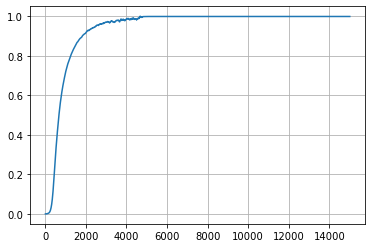

In [43]:
plt.plot(overlap[0])
plt.grid()

# Analisando a mudança dos overlaps

In [44]:
overlap_std = np.std(overlap, axis=1)
overlap_std

alt
7.5        0.000036
15.0       0.000047
22.5       0.000060
30.0       0.000074
37.5       0.000090
             ...   
14970.0    0.000000
14977.5    0.000000
14985.0    0.000000
14992.5    0.000000
15000.0    0.000000
Length: 2000, dtype: float64

In [45]:
alt_max = np.where(alt == 750)[0][0]

In [46]:
N = overlap.shape[1]
corr_matrix = np.zeros((N, N))

for i in range(N):
    for j in range(i, N):
        corr_matrix[i, j] = stats.pearsonr(overlap[i][:alt_max], overlap[j][:alt_max])[0]
        corr_matrix[j, i] = corr_matrix[i, j]

In [47]:
cont=0
for i in range(N):
    if corr_matrix[i, i] == 1:
        cont += 1

In [48]:
cont

60

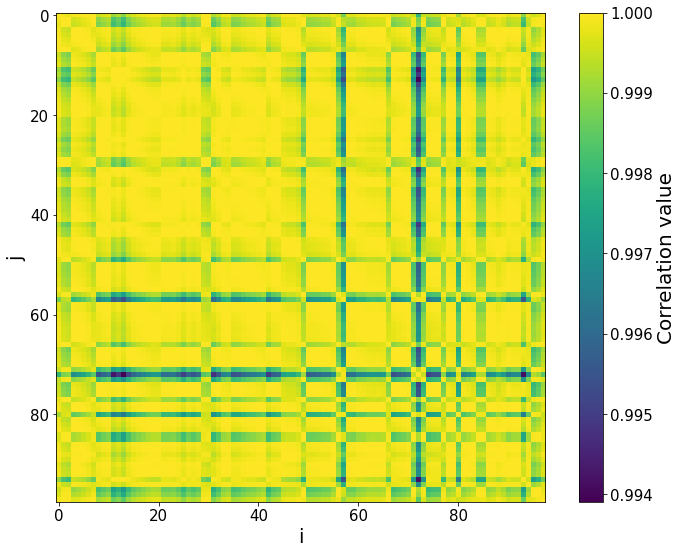

In [49]:
fig, ax = plt.subplots(figsize = (12,9))

psm = ax.imshow(corr_matrix)

cbar = fig.colorbar(psm, ax=ax, label = "Correlation value")
cbar.ax.tick_params(labelsize=15)

ax.set_xlabel("i", fontsize=20)

ax.set_ylabel("j", fontsize=20)

cbar.ax.tick_params(labelsize=15)

ax.tick_params(labelsize=15)

ax.figure.axes[-1].yaxis.label.set_size(20)

overlap_mean = np.mean(overlap, axis=1)

fig, axs = plt.subplots(2, 1, dpi=150, figsize=(6, 8))

xmax = 6.2

fig.subplots_adjust(hspace=0.3)
axs[0].plot(alt_o*1e-3, overlap_std, color='maroon')
axs[0].set_xlabel('Altitude (km)')
axs[0].set_xlim(-0.2, xmax)
axs[0].set_ylabel(r'$O(z)$ standard deviation')
axs[0].grid(linestyle='--', linewidth=0.8, alpha=0.4)

axs[1].plot(alt_o*1e-3, overlap_mean, color='maroon', label='Overlap mean')
axs[1].fill_between(alt_o*1e-3, overlap_mean-1*overlap_std, overlap_mean+1*overlap_std, facecolor='cornsilk', 
                 edgecolor='wheat', label='Overlap std', linestyle='-.',
                linewidth=0.8, alpha=1)
axs[1].grid(linestyle='--', linewidth=0.8, alpha=0.4)
axs[1].set_xlim(-0.2, xmax)
axs[1].set_xlabel('Altitude (km)')
axs[1].set_ylabel(r'$\langle O(z) \rangle$')
axs[1].legend()

plt.show()

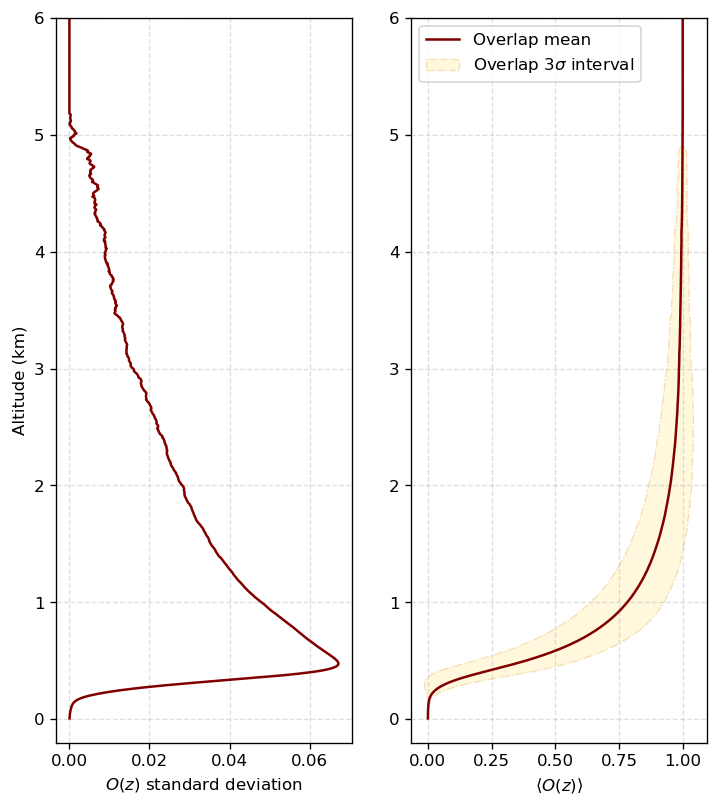

In [50]:
overlap_mean = np.mean(overlap, axis=1)

fig, axs = plt.subplots(1, 2, dpi=120, figsize=(7, 8))

xmax = 6.2
nsig = 3

fig.subplots_adjust(wspace=0.2)
axs[0].plot(overlap_std, alt_o*1e-3, color='maroon')
axs[0].set_ylabel('Altitude (km)')
#axs[0].set_xlim(-0.2, xmax)
axs[0].set_xlabel(r'$O(z)$ standard deviation')
axs[0].grid(linestyle='--', linewidth=0.8, alpha=0.4)
axs[0].set_ylim(-0.2, 6)
axs[1].plot(overlap_mean, alt_o*1e-3, color='maroon', label='Overlap mean')
axs[1].fill_betweenx(alt_o*1e-3, overlap_mean - nsig*overlap_std, overlap_mean + nsig*overlap_std, 
                     facecolor='cornsilk', edgecolor='wheat', label=r'Overlap ${} \sigma$ interval'.format(nsig), 
                     linestyle='-.', linewidth=0.8, alpha=1)
axs[1].grid(linestyle='--', linewidth=0.8, alpha=0.4)
#axs[1].set_xlim(-0.2, xmax)
#axs[1].set_ylabel('Altitude (km)')
axs[1].set_xlabel(r'$\langle O(z) \rangle$')
axs[1].legend(loc=0)
axs[1].set_ylim(-0.2, 6)
plt.savefig('Overlap_Analysis.png', dpi=200)
plt.show()


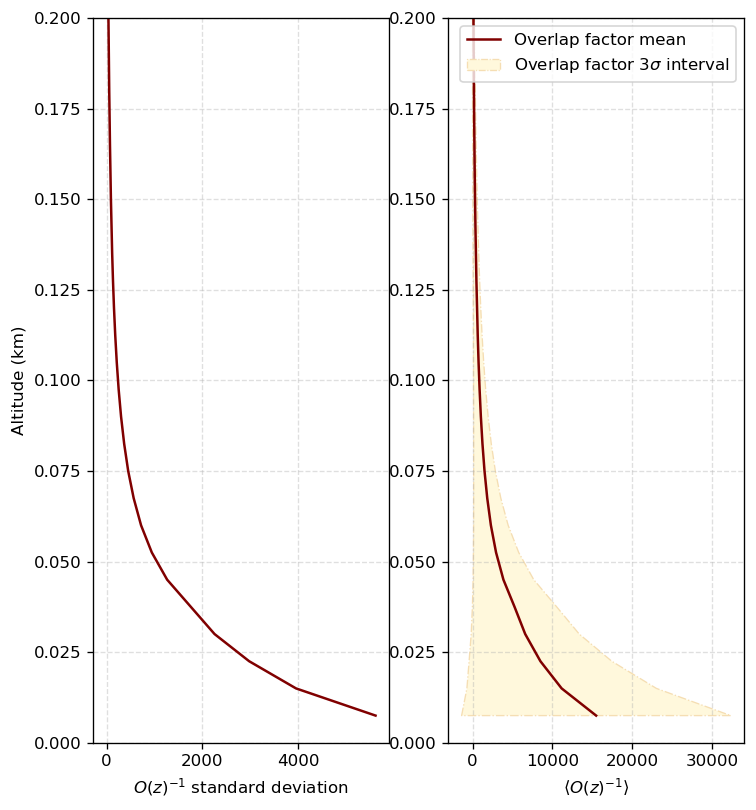

In [51]:
overlapf_mean = np.mean(1/overlap, axis=1)
overlapf_std = np.std(1/overlap, axis=1)

fig, axs = plt.subplots(1, 2, dpi=120, figsize=(7, 8))

xmax = 6.2
nsig = 3

fig.subplots_adjust(wspace=0.2)
axs[0].plot(overlapf_std, alt_o*1e-3, color='maroon')
axs[0].set_ylabel('Altitude (km)')
#axs[0].set_xlim(-0.2, xmax)
axs[0].set_xlabel(r'$O(z)^{-1}$ standard deviation')
axs[0].grid(linestyle='--', linewidth=0.8, alpha=0.4)
axs[0].set_ylim(0, 0.2)
axs[1].plot(overlapf_mean, alt_o*1e-3, color='maroon', label='Overlap factor mean')
axs[1].fill_betweenx(alt_o*1e-3, overlapf_mean - nsig*overlapf_std, overlapf_mean + nsig*overlapf_std, 
                     facecolor='cornsilk', edgecolor='wheat', label=r'Overlap factor ${} \sigma$ interval'.format(nsig), 
                     linestyle='-.', linewidth=0.8, alpha=1)
axs[1].grid(linestyle='--', linewidth=0.8, alpha=0.4)
#axs[1].set_xlim(-0.2, xmax)
#axs[1].set_ylabel('Altitude (km)')
axs[1].set_xlabel(r'$\langle O(z)^{-1} \rangle$')
axs[1].legend(loc=0)
axs[1].set_ylim(0, 0.2)
plt.savefig('OverlapFactor_Analysis.png', dpi=200)
plt.show()

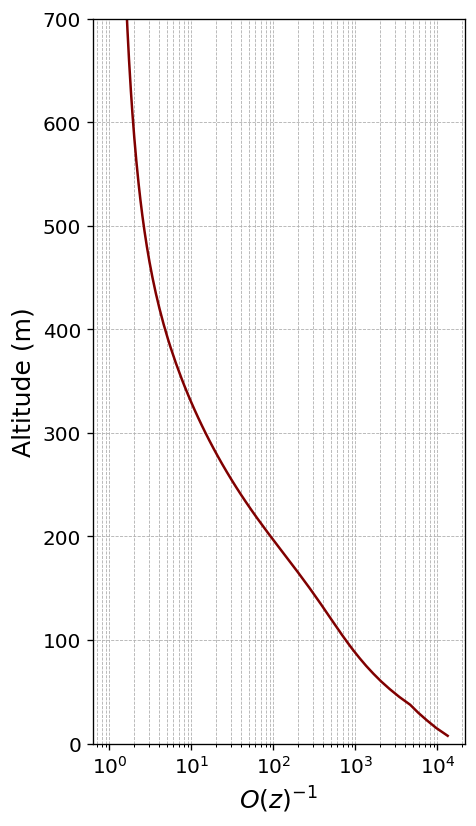

In [52]:
plt.figure(figsize=(4, 8), dpi=120)
plt.plot((1/overlap_mean), alt_o, color='maroon')
plt.ylabel('Altitude (m)', fontsize=15)
plt.xlabel(r'$O(z)^{-1}$', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xscale('log')
plt.grid(linewidth=0.5, alpha=1, linestyle='--', which='both')
plt.ylim(0, 700)
plt.show()

# built the simulated molecular signal

In [53]:
s355_bg = n_s355 - bg          # Subtraindo o background
s355_bg = np.concatenate((s355_bg[:2000]/overlap_mean.values, s355_bg[2000:]), axis=0)   #Dividindo pelo overlap
#n_alt = alt[11:3145]       #COMENTEI ISSO AQUI
n_s355 = s355_bg

In [54]:
meteo_alt = n_alt

In [55]:
model = (beta_mol * np.exp(-2*integrate.cumtrapz(alpha_mol, meteo_alt, initial=0))) / meteo_alt**2

(1e-10, 1000000000000000.0)

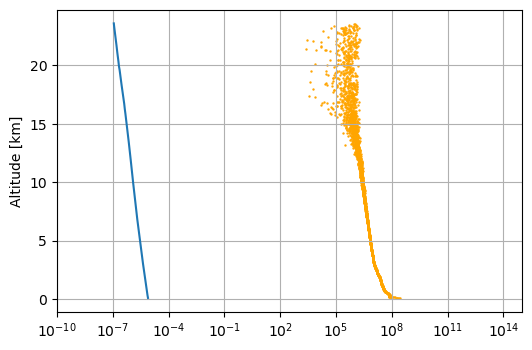

In [56]:
plt.figure(dpi=100)
plt.semilogx(model*meteo_alt*meteo_alt, meteo_alt*1e-3)
plt.scatter((n_s355)*n_alt*n_alt, n_alt*1e-3, s=0.5, c='orange')
plt.grid(True)
plt.ylabel('Altitude [km]')
plt.xlim(1e-10, 1e15)

## Determinando a região do ajuste

In [57]:
alt_min = 8.   # km
alt_max = 15   # km

index_min = int(alt_min*1e3/7.5)
index_max = int(alt_max*1e3/7.5)

Text(0, 0.5, 'Measured signal')

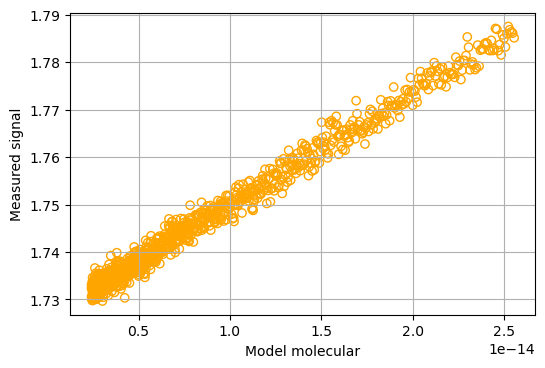

In [58]:
plt.figure(dpi=100)
plt.scatter(model[index_min:index_max], s355[index_min:index_max], facecolors = 'none', edgecolors = 'orange')
plt.grid(True)
plt.xlabel('Model molecular')
plt.ylabel('Measured signal')

In [59]:
f = lambda x, a, b: a*x + b

fit = optimize.curve_fit(f, model[index_min:index_max], n_s355[index_min:index_max], p0=(1e13, 116))

a = fit[0][0]
b = fit[0][1]

fit

(array([ 2.28226009e+12, -2.12616834e-03]),
 array([[ 8.50016511e+19, -7.82401203e+05],
        [-7.82401203e+05,  1.04407919e-08]]))

Text(0, 0.5, 'Measured signal')

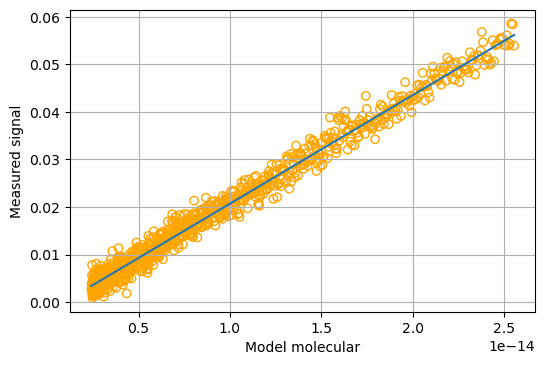

In [60]:
plt.figure(dpi=100)
plt.scatter(model[index_min:index_max], n_s355[index_min:index_max], facecolors = 'none', edgecolors = 'orange')
plt.plot(model[index_min:index_max], f(model[index_min:index_max], a, b))
plt.grid(True)
plt.xlabel('Model molecular')
plt.ylabel('Measured signal')

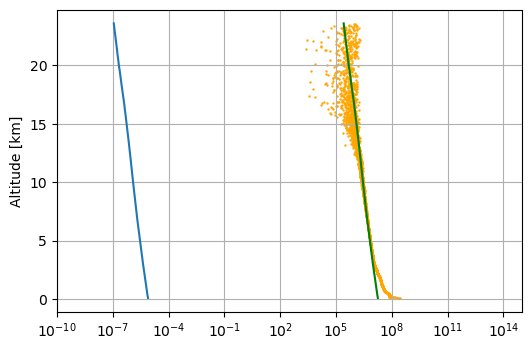

In [61]:
plt.figure(dpi=100)
plt.semilogx(model*meteo_alt*meteo_alt, meteo_alt*1e-3)
plt.scatter((n_s355)*n_alt*n_alt, n_alt*1e-3, c='orange', s=0.5)
plt.semilogx(model*a*meteo_alt*meteo_alt, meteo_alt*1e-3, c='green')
plt.grid(True)
plt.ylabel('Altitude [km]')
plt.xlim(1e-10, 1e15)
plt.savefig('fig8', dpi=200)

In [62]:
%run fernald_new1.ipynb

# Devemos sempre entrar com vetores coluna no algoritmo de inversao

zref = np.array([6*1e3, 14*1e3])
LR = 28.

z     = n_alt[:, None]
pr    = n_s355[:, None]
ref   = zref[:, None]
lambd = 355*1e-9
LidarRatio = LR
Pair  = newPair[:, None]
Tair  = newTair[:, None]


beta_par, alpha_par, LR_par, model_mol, ab_fit = fernald_new1(z,pr,ref,lambd,LidarRatio,Pair,Tair)

## Devemos restringir o plot a partir de 750m porque antes o overlap varia mto

In [63]:
lim = 100
beta_par['aer']  = beta_par['aer'][lim:]
beta_par['mol']  = beta_par['mol'][lim:]
beta_par['tot']  = beta_par['tot'][lim:]
alpha_par['aer'] = alpha_par['aer'][lim:]
alpha_par['mol'] = alpha_par['mol'][lim:]
alpha_par['tot'] = alpha_par['tot'][lim:]
n_alt = n_alt[lim:]

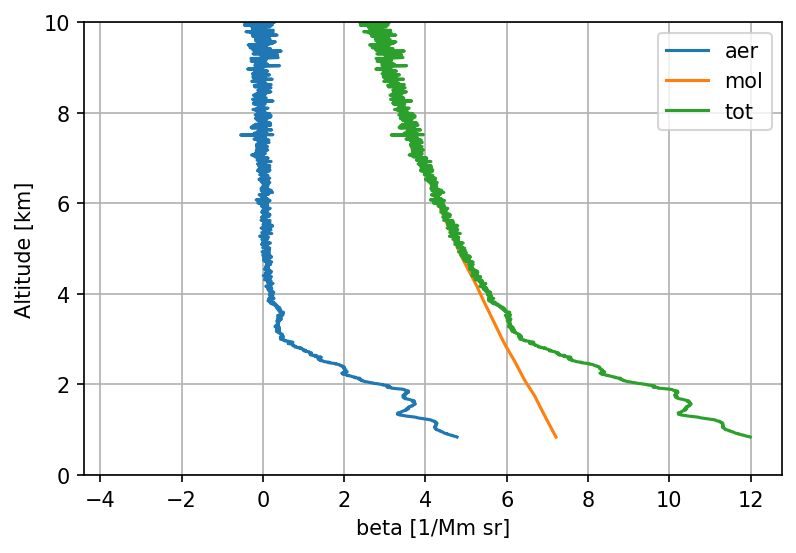

In [64]:
plt.figure(dpi=150)
plt.plot(beta_par['aer']*1e6, n_alt*1e-3)
plt.plot(beta_par['mol']*1e6, n_alt*1e-3)
plt.plot(beta_par['tot']*1e6, n_alt*1e-3)
plt.grid(True)
plt.legend(['aer', 'mol', 'tot'])
# plt.xlim(-5, 14)
plt.ylim(0, 10)
plt.xlabel('beta [1/Mm sr]')
plt.ylabel('Altitude [km]')
plt.savefig('backscatter', dpi=200)

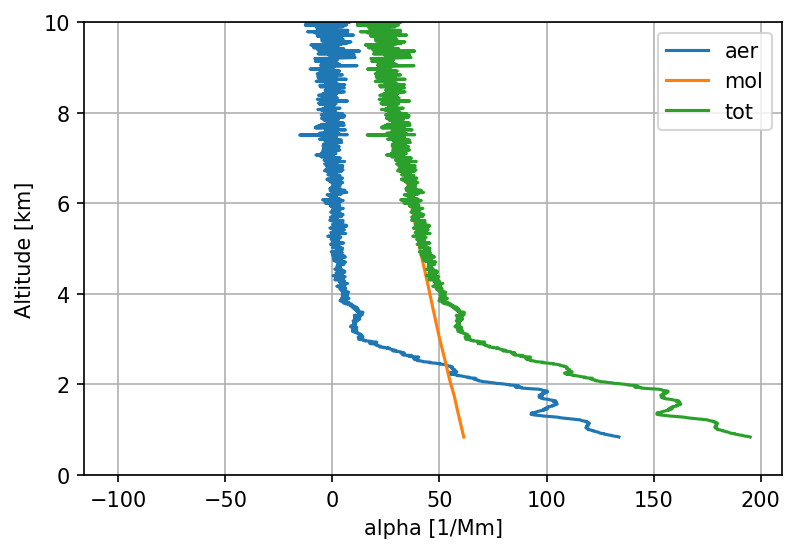

In [65]:
plt.figure(dpi=150)
plt.plot(alpha_par['aer']*1e6, n_alt*1e-3)
plt.plot(alpha_par['mol']*1e6, n_alt*1e-3)
plt.plot(alpha_par['tot']*1e6, n_alt*1e-3)
plt.grid(True)
plt.legend(['aer', 'mol', 'tot'])
# plt.xlim(-5, 14)
plt.ylim(0, 10)
plt.xlabel('alpha [1/Mm]')
plt.ylabel('Altitude [km]')
plt.savefig('alpha', dpi=200)